# Test mini_tVAE

### 1. Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/mfacotti/martin/tVAE_project')
from mini_tvae_v2 import MiniTVAE
from data_load import DataLoader


from sdv.evaluation.single_table import run_diagnostic, evaluate_quality
from sdv.metadata import Metadata

### 2. Load data

In [2]:
data_loader = DataLoader(
    csv_filename='../rhc.csv',
    meta_filename='../metadata.json'
)
data, discrete_columns = data_loader.load_data()

data.head()

Detected missing values in 5 columns:
  - cat2: 4535 missing values (79.1%)
  - dschdte: 1 missing values (0.0%)
  - dthdte: 2013 missing values (35.1%)
  - adld3p: 4296 missing values (74.9%)
  - urin1: 3028 missing values (52.8%)
No discrete columns found in metadata. Inferring from data types...
Loaded dataset with 5735 rows and 63 columns
Identified 21 discrete columns


,Unnamed: 0,cat1,cat2,ca,sadmdte,dschdte,dthdte,lstctdte,death,cardiohx,...,meta,hema,seps,trauma,ortho,adld3p,urin1,race,income,ptid
0,1,COPD,NaN,Yes,11142,11151.0,NaN,11382,No,0,...,No,No,No,No,No,0.0,NaN,white,Under $11k,5
1,2,MOSF w/Sepsis,NaN,No,11799,11844.0,11844.0,11844,Yes,1,...,No,No,Yes,No,No,NaN,1437.0,white,Under $11k,7
2,3,MOSF w/Malignancy,MOSF w/Sepsis,Yes,12083,12143.0,NaN,12400,No,0,...,No,No,No,No,No,NaN,599.0,white,$25-$50k,9
3,4,ARF,NaN,No,11146,11183.0,11183.0,11182,Yes,0,...,No,No,No,No,No,NaN,NaN,white,$11-$25k,10
4,5,MOSF w/Sepsis,NaN,No,12035,12037.0,12037.0,12036,Yes,0,...,No,No,No,No,No,NaN,64.0,white,Under $11k,11


### 3. Training

In [3]:
def train_tvae_model(data, discrete_columns, hyperparams=None):
    """
    Create and train a MiniTVAE model with the provided hyperparameters.
    
    Parameters:
    -----------
    data : DataFrame
        The training data
    discrete_columns : list
        List of discrete/categorical columns
    hyperparams : dict, optional
        Dictionary of hyperparameters for the MiniTVAE model
        
    Returns:
    --------
    MiniTVAE
        The trained model
    """
    # Default hyperparameters
    default_params = {
        'embedding_dim': 128,
        'compress_dims': (128, 128),
        'decompress_dims': (128, 128),
        'l2scale': 1e-5,
        'batch_size': 500,
        'epochs': 200,
        'loss_factor': 2,
        'cuda': True, # Set to False if running on CPU
        'verbose': True
    }
    
    # Use provided hyperparameters or default values
    params = default_params.copy()
    if hyperparams:
        params.update(hyperparams)
    
    print("Training Mini TVAE model with the following parameters:")
    for key, value in params.items():
        print(f"  {key}: {value}")
    
    # Create and train the model
    model = MiniTVAE(**params)
    model.fit(data, discrete_columns)
    
    return model

# add feature to save model
model = train_tvae_model(data, discrete_columns)

Training Mini TVAE model with the following parameters:
  embedding_dim: 128
  compress_dims: (128, 128)
  decompress_dims: (128, 128)
  l2scale: 1e-05
  batch_size: 500
  epochs: 200
  loss_factor: 2
  cuda: True
  verbose: True
Note: Found NaN values in columns: ['cat2', 'dschdte', 'dthdte', 'adld3p', 'urin1']. These will be handled using the 'from_column' approach.


/home/mfacotti/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning:

Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.

/home/mfacotti/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning:

Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.

/home/mfacotti/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning:

Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.

/home/mfacotti/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning:

Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.

/home/mfacotti/.local/lib/python3.10/sit

Original compress_dims: (128, 128)
Data dimensions after transformation: 401
Adjusted compress_dims: (np.int64(401), 128, 128)
Adjusted decompress_dims: (128, 128, np.int64(401))


Loss: -67.237: 100%|██████████| 200/200 [04:58<00:00,  1.49s/it]


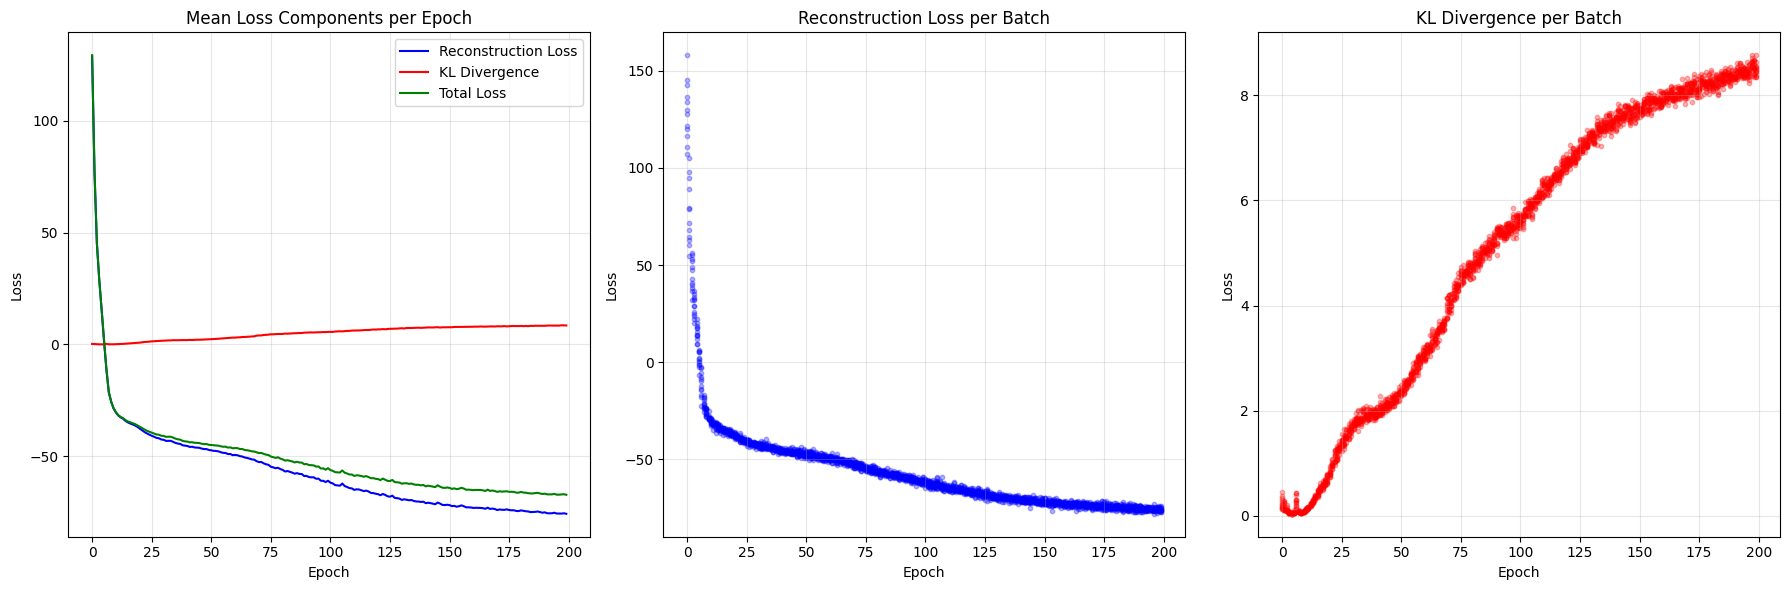

In [4]:
def plot_loss_over_epochs(loss_values):
    """Plot the loss components across epochs."""
    # Group by epoch and calculate mean loss components per epoch
    epoch_loss = loss_values.groupby('Epoch')[['loss_1', 'loss_2', 'total_loss']].mean().reset_index()
    
    plt.figure(figsize=(18, 6))
    
    # Plot mean loss components per epoch
    plt.subplot(1, 3, 1)
    plt.plot(epoch_loss['Epoch'], epoch_loss['loss_1'], 'b-', label='Reconstruction Loss')
    plt.plot(epoch_loss['Epoch'], epoch_loss['loss_2'], 'r-', label='KL Divergence')
    plt.plot(epoch_loss['Epoch'], epoch_loss['total_loss'], 'g-', label='Total Loss')
    plt.title('Mean Loss Components per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot batch reconstruction losses across epochs
    plt.subplot(1, 3, 2)
    for epoch in sorted(loss_values['Epoch'].unique()):
        epoch_data = loss_values[loss_values['Epoch'] == epoch]
        plt.scatter([epoch] * len(epoch_data), epoch_data['loss_1'], 
                    alpha=0.3, s=10, color='blue')
    plt.title('Reconstruction Loss per Batch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    
    # Plot batch KL divergence losses across epochs
    plt.subplot(1, 3, 3)
    for epoch in sorted(loss_values['Epoch'].unique()):
        epoch_data = loss_values[loss_values['Epoch'] == epoch]
        plt.scatter([epoch] * len(epoch_data), epoch_data['loss_2'], 
                    alpha=0.3, s=10, color='red')
    plt.title('KL Divergence per Batch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    
plot_loss_over_epochs(model.loss_values)

### 5. Generation

In [5]:
def generate_synthetic_data(model, num_samples, save_path=None):
    """
    Generate synthetic data from the trained model.
    
    Parameters:
    -----------
    model : MiniTVAE
        The trained model
    num_samples : int
        Number of samples to generate
    save_path : str, optional
        Path to save the synthetic data
        
    Returns:
    --------
    DataFrame
        The generated synthetic data
    """
    print(f"Generating {num_samples} synthetic samples...")
    synthetic_data = model.sample(num_samples)
    
    if save_path:
        synthetic_data.to_csv(save_path, index=False)
        print(f"Synthetic data saved to '{save_path}'")
    
    return synthetic_data

generate_synthetic_data(model, 10000, 'synthetic_rhc.csv') # or fit the number of samples to the original dataset with len(data)


Generating 10000 synthetic samples...


/home/mfacotti/martin/tVAE_project/test_mini_tvae/mini_data_trans.py:490: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.0931052   0.0415648   0.06403171 ...  0.20694713  0.12407962
 -0.07331925]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.

/home/mfacotti/martin/tVAE_project/test_mini_tvae/mini_data_trans.py:490: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.04079396 -0.06847082 -0.09993816 ...  0.13433006 -0.2646892
 -0.359945  ]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.

/home/mfacotti/martin/tVAE_project/test_mini_tvae/mini_data_trans.py:490: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.15909485  0.18843155  0.14507276 ...  0.3861931   0.26056705
 -0.59342398]' ha

Synthetic data saved to 'synthetic_rhc.csv'


,Unnamed: 0,cat1,cat2,ca,sadmdte,dschdte,dthdte,lstctdte,death,cardiohx,...,meta,hema,seps,trauma,ortho,adld3p,urin1,race,income,ptid
0,4533,ARF,NaN,No,10877,NaN,NaN,10893,Yes,0,...,No,No,No,No,No,NaN,NaN,white,Under $11k,7335
1,4450,MOSF w/Sepsis,NaN,No,11108,NaN,NaN,11002,Yes,0,...,No,No,No,No,No,NaN,NaN,white,Under $11k,8747
2,4486,ARF,NaN,No,12014,NaN,NaN,12447,No,0,...,No,No,No,No,No,NaN,NaN,white,Under $11k,7439
3,1312,ARF,NaN,No,11765,NaN,NaN,11987,Yes,0,...,No,No,No,No,No,NaN,NaN,white,Under $11k,1499
4,3957,MOSF w/Malignancy,NaN,Yes,11164,NaN,NaN,11428,Yes,0,...,No,No,No,No,No,NaN,NaN,white,Under $11k,7735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,4639,CHF,NaN,No,12214,NaN,NaN,12627,No,0,...,No,No,No,No,No,NaN,NaN,white,Under $11k,8107
9996,4531,Coma,NaN,No,11884,NaN,NaN,12023,Yes,0,...,No,No,No,No,No,NaN,NaN,white,Under $11k,7386
9997,4717,CHF,NaN,No,11419,NaN,NaN,11559,Yes,1,...,No,No,No,No,No,NaN,NaN,white,Under $11k,9362
9998,1684,ARF,NaN,No,11942,NaN,NaN,12458,No,0,...,No,No,No,No,No,NaN,NaN,white,Under $11k,2517


In [6]:
def compare_statistics(original_data, synthetic_data, discrete_columns, 
                       num_numeric=5, num_categorical=3, num_categories=5, 
                       exclude_first_column=True):
    """
    Compare statistics between original and synthetic data.
    
    Parameters:
    -----------
    original_data : DataFrame
        The original data
    synthetic_data : DataFrame
        The synthetic data
    discrete_columns : list
        List of discrete/categorical columns
    num_numeric : int, optional
        Number of numeric columns to compare
    num_categorical : int, optional
        Number of categorical columns to compare
    num_categories : int, optional
        Number of categories to display per categorical column
    exclude_first_column : bool, optional
        Whether to exclude the first column (patient ID) from the comparison
        
    Returns:
    --------
    dict
        Dictionary containing statistical comparison metrics
    """
    print("Comparing statistics between original and synthetic data:")
    
    # Create a copy of the dataframes to avoid modifying the originals
    orig_data = original_data.copy()
    synth_data = synthetic_data.copy()
    
    # Exclude the first column (patient ID) if requested
    if exclude_first_column:
        first_col = orig_data.columns[0]
        print(f"Excluding first column (patient ID): {first_col}")
        orig_data = orig_data.drop(columns=[first_col])
        if first_col in synth_data.columns:
            synth_data = synth_data.drop(columns=[first_col])
    
    # Initialize results dictionary to store comparison metrics
    results = {
        'numeric': {},
        'categorical': {}
    }
    
    # Compare numeric columns
    numeric_columns = orig_data.select_dtypes(include=['number']).columns
    if len(numeric_columns) > 0:
        print("\nNumeric columns comparison:")
        for col in numeric_columns[:num_numeric]:
            # Calculate statistics for original data
            orig_mean = orig_data[col].mean()
            orig_std = orig_data[col].std()
            orig_min = orig_data[col].min()
            orig_max = orig_data[col].max()
            
            # Calculate statistics for synthetic data
            syn_mean = synth_data[col].mean()
            syn_std = synth_data[col].std()
            syn_min = synth_data[col].min()
            syn_max = synth_data[col].max()
            
            # Calculate differences
            mean_diff = abs(orig_mean - syn_mean)
            std_diff = abs(orig_std - syn_std)
            
            # Store results
            results['numeric'][col] = {
                'original': {'mean': orig_mean, 'std': orig_std, 'min': orig_min, 'max': orig_max},
                'synthetic': {'mean': syn_mean, 'std': syn_std, 'min': syn_min, 'max': syn_max},
                'difference': {'mean': mean_diff, 'std': std_diff}
            }
            
            # Print comparison
            print(f"\nColumn: {col}")
            print(f"  Original - Mean: {orig_mean:.4f}, Std: {orig_std:.4f}, Range: [{orig_min:.4f}, {orig_max:.4f}]")
            print(f"  Synthetic - Mean: {syn_mean:.4f}, Std: {syn_std:.4f}, Range: [{syn_min:.4f}, {syn_max:.4f}]")
            print(f"  Difference - Mean: {mean_diff:.4f}, Std: {std_diff:.4f}")
    
    # Compare categorical columns
    valid_discrete_columns = [col for col in discrete_columns if col in orig_data.columns]
    if len(valid_discrete_columns) > 0:
        print("\nCategorical columns comparison (value counts percentage):")
        for col in valid_discrete_columns[:num_categorical]:
            print(f"\nColumn: {col}")
            
            # Calculate distributions
            orig_counts = orig_data[col].value_counts(normalize=True).sort_index()
            syn_counts = synth_data[col].value_counts(normalize=True).sort_index()
            
            # Combine indices to ensure we show all categories
            all_cats = sorted(list(set(list(orig_counts.index) + list(syn_counts.index))))
            cat_results = {}
            
            # Print and store category comparisons
            for cat in all_cats[:num_categories]:
                orig_pct = orig_counts.get(cat, 0) * 100
                syn_pct = syn_counts.get(cat, 0) * 100
                diff_pct = abs(orig_pct - syn_pct)
                
                cat_results[cat] = {
                    'original': orig_pct,
                    'synthetic': syn_pct,
                    'difference': diff_pct
                }
                
                print(f"  {cat}: Original {orig_pct:.1f}%, Synthetic {syn_pct:.1f}%, Diff {diff_pct:.1f}%")
            
            # Store results for this column
            results['categorical'][col] = cat_results
    
    return results


stats = compare_statistics(data, generate_synthetic_data(model, len(data)), discrete_columns, exclude_first_column=True)

Generating 5735 synthetic samples...


/home/mfacotti/martin/tVAE_project/test_mini_tvae/mini_data_trans.py:490: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.03099758 -0.08179575  0.1444082  ... -0.08263096 -0.2069567
 -0.34069279]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.

/home/mfacotti/martin/tVAE_project/test_mini_tvae/mini_data_trans.py:490: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.01001035  0.13141246 -0.23783234 ...  0.04033166 -0.37606607
 -0.10609981]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.

/home/mfacotti/martin/tVAE_project/test_mini_tvae/mini_data_trans.py:490: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.13429569 -0.14424305  0.21964594 ...  0.2111004  -0.30777364
  0.37510964]' ha

Comparing statistics between original and synthetic data:
Excluding first column (patient ID): Unnamed: 0

Numeric columns comparison:

Column: sadmdte
  Original - Mean: 11638.6863, Std: 513.9678, Range: [10754.0000, 12441.0000]
  Synthetic - Mean: 11659.8166, Std: 414.9135, Range: [10743.0000, 12493.0000]
  Difference - Mean: 21.1303, Std: 99.0543

Column: dschdte
  Original - Mean: 11660.0504, Std: 513.4473, Range: [10757.0000, 12560.0000]
  Synthetic - Mean: nan, Std: nan, Range: [nan, nan]
  Difference - Mean: nan, Std: nan

Column: dthdte
  Original - Mean: 11753.8692, Std: 538.8123, Range: [10757.0000, 12783.0000]
  Synthetic - Mean: nan, Std: nan, Range: [nan, nan]
  Difference - Mean: nan, Std: nan

Column: lstctdte
  Original - Mean: 11781.2579, Std: 524.0942, Range: [10756.0000, 12644.0000]
  Synthetic - Mean: 11791.1545, Std: 473.8830, Range: [10740.0000, 12704.0000]
  Difference - Mean: 9.8966, Std: 50.2112

Column: cardiohx
  Original - Mean: 0.1766, Std: 0.3814, Range: [

/home/mfacotti/martin/tVAE_project/test_mini_tvae/mini_data_trans.py:490: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.07538647 -0.05204557 -0.30241067 ... -0.13828091 -0.28202056
 -0.13844756]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.

/home/mfacotti/martin/tVAE_project/test_mini_tvae/mini_data_trans.py:490: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.38129867  0.28195165  0.01011696 ... -0.05178332  0.01032071
  0.08093007]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.

/home/mfacotti/martin/tVAE_project/test_mini_tvae/mini_data_trans.py:490: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.09526852 -0.21024074 -0.04913982 ...  0.19269146 -0.00133826
  0.15824259]' h

### 5.Evaluation

In [7]:
data = pd.read_csv('../rhc.csv')
metadata = Metadata.load_from_json('../metadata.json')

# Load the synthetic data
synthetic_data = pd.read_csv('synthetic_rhc.csv')

In [8]:
diagnostic = run_diagnostic(
    real_data=data,
    synthetic_data=synthetic_data,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 63/63 [00:00<00:00, 453.70it/s]|
Data Validity Score: 98.78%



/home/mfacotti/.local/lib/python3.10/site-packages/sdmetrics/single_column/statistical/boundary_adherence.py:58: RuntimeWarning:

invalid value encountered in scalar divide



(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 186.65it/s]|
Data Structure Score: 96.88%

Overall Score (Average): 97.83%



In [9]:
quality_report = evaluate_quality(
    data,
    synthetic_data,
    metadata
)

# quality_report.save(filepath='results/diagnostic_report.pkl')
# quality_report = QualityReport.load('results/quality_report.pkl')


Generating report ...

(1/2) Evaluating Column Shapes: |█▎        | 8/63 [00:00<00:02, 25.04it/s]|

/home/mfacotti/.local/lib/python3.10/site-packages/sdmetrics/single_column/statistical/kscomplement.py:68: SmallSampleWarning:

One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.



(1/2) Evaluating Column Shapes: |██████████| 63/63 [00:12<00:00,  5.02it/s]|
Column Shapes Score: 86.55%

(2/2) Evaluating Column Pair Trends: |██████████| 1953/1953 [00:21<00:00, 91.66it/s]| 
Column Pair Trends Score: 67.38%

Overall Score (Average): 76.96%



In [10]:
quality_report.get_details('Column Shapes')
# KSComplement for numerical columns
# TVComplement for categorical columns

,Column,Metric,Score,Error
0,cat1,TVComplement,0.925906,None
1,cat2,TVComplement,NaN,IncomputableMetricError: The TVComplement metr...
2,ca,TVComplement,0.964457,None
3,sadmdte,KSComplement,0.854494,None
4,dschdte,KSComplement,NaN,None
...,...,...,...,...
56,ortho,TVComplement,0.999579,None
57,adld3p,TVComplement,NaN,IncomputableMetricError: The TVComplement metr...
58,urin1,KSComplement,NaN,None
59,race,TVComplement,0.806481,None


In [11]:
quality_report.get_details('Column Pair Trends')

,Column 1,Column 2,Metric,Score,Real Correlation,Synthetic Correlation,Error
0,cat1,cat2,ContingencySimilarity,0.730788,NaN,NaN,None
1,cat1,ca,ContingencySimilarity,0.898657,NaN,NaN,None
2,cat1,sadmdte,ContingencySimilarity,0.601181,NaN,NaN,None
3,cat1,dschdte,ContingencySimilarity,0.000349,NaN,NaN,None
4,cat1,dthdte,ContingencySimilarity,0.351526,NaN,NaN,None
...,...,...,...,...,...,...,...
1825,adld3p,race,ContingencySimilarity,0.612933,NaN,NaN,None
1826,adld3p,income,ContingencySimilarity,0.532484,NaN,NaN,None
1827,urin1,race,ContingencySimilarity,0.448504,NaN,NaN,None
1828,urin1,income,ContingencySimilarity,0.417575,NaN,NaN,None


In [12]:
fig1 = quality_report.get_visualization('Column Pair Trends')
fig2 = quality_report.get_visualization('Column Shapes')

fig1.show()
fig2.show() # This one is not working properly